In [1]:
# Imports
import os
import time
import timeit
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import math
# seaborn optional
try:
    import seaborn as sns
    sns.set(style='whitegrid')
except Exception:
    pass

# For reproducibility in mock embeddings
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# 1) Data preparation — create 8 mock fashion products with 'vibe' tags
products = [
    {'id': 1, 'name': 'Boho Dress', 'desc': 'Flowy maxi dress with earthy tones, perfect for festivals and beach escapes.', 'vibes': ['boho','festival','earthy']},
    {'id': 2, 'name': 'Minimal Tee', 'desc': 'Crisp white tee in soft cotton, clean lines for everyday minimalist style.', 'vibes': ['minimal','everyday','clean']},
    {'id': 3, 'name': 'Urban Bomber', 'desc': 'Lightweight bomber jacket with reflective trim—street-ready and energetic.', 'vibes': ['urban','energetic','street']},
    {'id': 4, 'name': 'Cozy Knit', 'desc': 'Chunky knit sweater in warm neutral colors for cozy indoor days.', 'vibes': ['cozy','warm','indoor']},
    {'id': 5, 'name': 'Sport Luxe Leggings', 'desc': 'High-waisted leggings with subtle sheen for athleisure and studio workouts.', 'vibes': ['sporty','luxe','active']},
    {'id': 6, 'name': 'Vintage Denim', 'desc': 'Washed denim jacket with patched details, retro and casual.', 'vibes': ['vintage','casual','retro']},
    {'id': 7, 'name': 'Night Out Slip', 'desc': 'Satin slip dress with a flattering cut—perfect for evening dates and parties.', 'vibes': ['glam','evening','party']},
    {'id': 8, 'name': 'Earth Tone Blouse', 'desc': 'Soft blouse in terracotta and olive—calm, earthy, and polished.', 'vibes': ['earthy','calm','polished']},
]

df = pd.DataFrame(products)
df[['id','name','desc','vibes']].head(10)

,id,name,desc,vibes
0,1,Boho Dress,"Flowy maxi dress with earthy tones, perfect fo...","[boho, festival, earthy]"
1,2,Minimal Tee,"Crisp white tee in soft cotton, clean lines fo...","[minimal, everyday, clean]"
2,3,Urban Bomber,Lightweight bomber jacket with reflective trim...,"[urban, energetic, street]"
3,4,Cozy Knit,Chunky knit sweater in warm neutral colors for...,"[cozy, warm, indoor]"
4,5,Sport Luxe Leggings,High-waisted leggings with subtle sheen for at...,"[sporty, luxe, active]"
5,6,Vintage Denim,"Washed denim jacket with patched details, retr...","[vintage, casual, retro]"
6,7,Night Out Slip,Satin slip dress with a flattering cut—perfect...,"[glam, evening, party]"
7,8,Earth Tone Blouse,"Soft blouse in terracotta and olive—calm, eart...","[earthy, calm, polished]"


In [3]:
# 2) Embedding utilities
# NOTE: This notebook gives you two ways to create embeddings:
#  1> Mock (fake) embeddings
#     - These are generated inside the notebook.
#     - They do NOT require the internet or an API key.
#     -They are useful for testing and practicing.
#  2>Real OpenAI embeddings
#     -This uses the OpenAI API to generate real embeddings.
#     -This method needs internet and an API key.
# with a call to the OpenAI Python client as shown below (and remove the mock).

EMBED_DIM = 1536  # typical dimension for OpenAI text-embedding-ada-002; we mock with that dim

def mock_embedding(text, dim=EMBED_DIM):
    """Deterministic mock embedding using hashing + random seed so outputs are stable across runs."""
    # Create a reproducible pseudo-random vector from the text
    h = abs(hash(text)) % (10**8)
    rng = np.random.RandomState(h % (2**32))
    vec = rng.normal(size=(dim,))
    # Normalize to unit vector for cosine similarity correctness
    vec = vec / (np.linalg.norm(vec) + 1e-12)
    return vec.tolist()

# Example OpenAI template (commented out) - enable when you have network + API key
# from openai import OpenAI
# client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
# def openai_embedding(text, model='text-embedding-ada-002'):
#     resp = client.embeddings.create(model=model, input=text)
#     return resp.data[0].embedding

# Wrapper: choose which function to call
USE_MOCK = True
def get_embedding(text):
    if USE_MOCK:
        return mock_embedding(text)
    else:
        # return openai_embedding(text)
        raise RuntimeError('OpenAI embedding not enabled. Set USE_MOCK=False and configure API client.')

In [4]:
# 3) Compute embeddings for each product description (and store in dataframe)
embs = []
start = time.time()
for i, row in df.iterrows():
    emb = get_embedding(row['desc'])
    embs.append(emb)
end = time.time()
df['embedding'] = embs
print(f"Computed {len(embs)} embeddings in {end-start:.3f} seconds.")

Computed 8 embeddings in 0.036 seconds.


In [5]:
# 4) Prepare embeddings matrix (numpy) for similarity computations
X = np.vstack(df['embedding'].values)   # shape: (n_products, dim)
print('Embeddings matrix shape:', X.shape)

Embeddings matrix shape: (8, 1536)


In [6]:
# 5) Query embedding + cosine similarity search (returns top-k)
def find_top_k(query, k=3, return_scores=True):
    q_emb = np.array(get_embedding(query)).reshape(1, -1)
    sims = cosine_similarity(q_emb, X)[0]   # shape: (n_products,)
    idx_sorted = np.argsort(sims)[::-1]     # descending
    top_idx = idx_sorted[:k]
    results = []
    for idx in top_idx:
        results.append({'id': int(df.iloc[idx]['id']),
                        'name': df.iloc[idx]['name'],
                        'desc': df.iloc[idx]['desc'],
                        'vibes': df.iloc[idx]['vibes'],
                        'score': float(sims[idx])})
    if return_scores:
        return results, sims
    else:
        return results

# Quick manual test
query = 'energetic urban chic'
res, sims_all = find_top_k(query, k=3)
print('Query:', query)
for r in res:
    print(f" - {r['name']} (score: {r['score']:.4f}) — {r['vibes']}")

Query: energetic urban chic
 - Earth Tone Blouse (score: 0.0328) — ['earthy', 'calm', 'polished']
 - Sport Luxe Leggings (score: 0.0271) — ['sporty', 'luxe', 'active']
 - Boho Dress (score: 0.0076) — ['boho', 'festival', 'earthy']


In [7]:
# 6) Test & simple evaluation across 3 example queries
queries = [
    ('energetic urban chic', 'urban'),
    ('cozy indoor reading', 'cozy'),
    ('earthy festival vibes', 'boho')
]

results_log = []
t_latencies = []

for q, expected_tag in queries:
    t0 = timeit.default_timer()
    res, sims_all = find_top_k(q, k=3)
    t1 = timeit.default_timer()
    latency_ms = (t1 - t0) * 1000
    t_latencies.append(latency_ms)
    # consider success if top-1 contains the expected tag in its vibes
    top1 = res[0]
    success = expected_tag in top1['vibes']
    max_score = res[0]['score']
    results_log.append({'query': q, 'expected_tag': expected_tag, 'top1': top1['name'], 'score': max_score, 'success': success, 'latency_ms': latency_ms})

results_df = pd.DataFrame(results_log)
display(results_df)
print('\nAverage latency (ms):', np.mean(t_latencies))

,query,expected_tag,top1,score,success,latency_ms
0,energetic urban chic,urban,Earth Tone Blouse,0.032764,False,14.0790
1,cozy indoor reading,cozy,Night Out Slip,0.036583,False,11.7040
2,earthy festival vibes,boho,Urban Bomber,0.031505,False,5.6205



Average latency (ms): 10.46783352891604


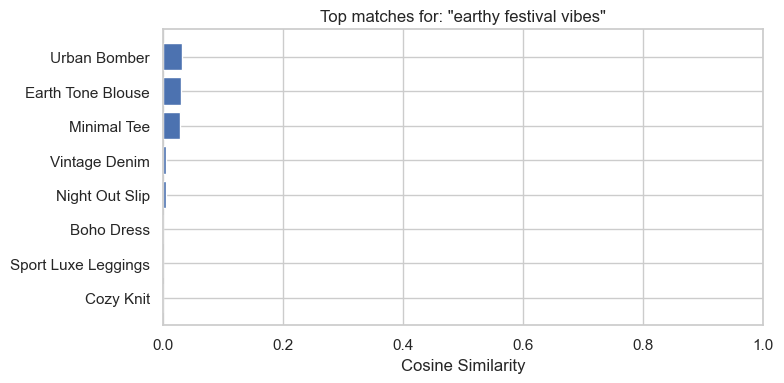

In [8]:
# 7) Plot similarity scores for top results of last query (visual)
last_query = queries[-1][0]
res, sims_all = find_top_k(last_query, k=8)
names = [r['name'] for r in res]
scores = [r['score'] for r in res]

plt.figure(figsize=(8,4))
plt.barh(range(len(scores))[::-1], scores)  # horizontal bar chart
plt.yticks(range(len(scores))[::-1], names)
plt.xlabel('Cosine Similarity')
plt.title(f'Top matches for: "{last_query}"')
plt.xlim(0,1)
plt.tight_layout()
plt.show()